# Classifying real vs. fake photons from $tt\gamma$, $t\bar{t}$ events

In [1]:
from coffea import hist, util

import coffea.processor as processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import awkward as ak
import numpy as np
import uproot

import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

In [2]:
class PhotonSelector(processor.ProcessorABC):
    def __init__(self, isMC=True):
        
        self.isMC = isMC

        # Declare axes
        dataset_axis = hist.Cat("dataset","Dataset")

        photon_pt_axis = hist.Bin("pt","photon $p_{T}$ [GeV]", 40, 0, 400)
        photon_eta_axis = hist.Bin("eta","photon $\eta$", 50, -2.5, 2.5)
        photon_phi_axis = hist.Bin("phi","photon $\phi$", 64, -3.2, 3.2)
        photon_reliso_all_axis = hist.Bin("reliso","photon pfRelIso03_all", 40, -0.5, 6)
        photon_reliso_chg_axis = hist.Bin("reliso","photon pfRelIso03_chg", 40, -0.5, 6)
        photon_sieie_axis = hist.Bin("sieie","photon sigma I eta I eta", 40, 0, 0.05)
        photon_r9_axis = hist.Bin("r9","photon R9", 40, -0.5, 1.5)
        photon_hoe_axis = hist.Bin("hoe","photon H over E", 40, -0.5, 1)
        photon_count_axis = hist.Bin("count","Photon number",12,-1,10)

        deltar_axis = hist.Bin("deltar","$\Delta R$", 50, -0.5, 4)
        
        mvaid_axis = hist.Bin("mvaid", "mvaID", 25,-1,1)

        photon_genPartFlav_axis = hist.Bin("flav","genPartFlav",40,-1,15)
        
        
        # Accumulator object: dictionary storing histograms & counters to be filled
        self._accumulator = processor.dict_accumulator({
            
            ## column accumulators
            'photon_pt': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_eta': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_phi': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_pfRelIso03_all': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_pfRelIso03_chg': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_sieie': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_r9': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_hoe': processor.column_accumulator(np.ndarray(shape=(0,))),
            'photon_count': processor.column_accumulator(np.ndarray(shape=(0,))),
            
            'deltaR_photon_lepton': processor.column_accumulator(np.ndarray(shape=(0,))),
            'deltaR_photon_jet': processor.column_accumulator(np.ndarray(shape=(0,))),
            
            'photon_mvaid': processor.column_accumulator(np.ndarray(shape=(0,))),
            'file': processor.column_accumulator(np.ndarray(shape=(0,))),
            
            'photon_genPartFlav': processor.column_accumulator(np.ndarray(shape=(0,))),
            
            
            ## histograms for features
            'photon_pt_hist': hist.Hist("Counts", dataset_axis, photon_pt_axis),
            'photon_eta_hist': hist.Hist("Counts", dataset_axis, photon_eta_axis),
            'photon_phi_hist': hist.Hist("Counts", dataset_axis, photon_phi_axis),
            'photon_reliso_all_hist': hist.Hist("Counts", dataset_axis, photon_reliso_all_axis),
            'photon_reliso_chg_hist': hist.Hist("Counts", dataset_axis, photon_reliso_chg_axis),
            'photon_sieie_hist': hist.Hist("Counts", dataset_axis, photon_sieie_axis),
            'photon_r9_hist': hist.Hist("Counts", dataset_axis, photon_r9_axis),
            'photon_hoe_hist': hist.Hist("Counts", dataset_axis, photon_hoe_axis),
            'photon_count_hist': hist.Hist("Counts", dataset_axis, photon_count_axis),
            
            'deltaR_photon_lepton_hist': hist.Hist("Counts", dataset_axis, deltar_axis),
            'deltaR_photon_jet_hist': hist.Hist("Counts", dataset_axis, deltar_axis),
            
            'photon_mvaid_hist': hist.Hist("Counts", dataset_axis, mvaid_axis),
            
            'photon_genPartFlav_hist': hist.Hist("Counts", dataset_axis, photon_genPartFlav_axis),
        }
        )

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        
        output = self.accumulator.identity()
        
        dataset = events.metadata['dataset']
        
        ######## object & event selection ########
        
        # muons
        muons=events.Muon
        muonSelectTight = ((muons.pt>30) &
                           (abs(muons.eta)<2.4) &
                           (muons.tightId) &
                           (muons.pfRelIso04_all < 0.15)
                          )
        tightMuons = muons[muonSelectTight]
        
        # jets & b-tagged jets
        jets=events.Jet
        jetSelectTight = ((jets.pt>30) &
                          (abs(jets.eta)<2.4) &
                          (jets.isTight)
                         )
        btaggedJetSelect = (jetSelectTight &
                           (jets.btagDeepB>0.6321)
                          )
        tightJets = jets[jetSelectTight]
        tightBJets = jets[btaggedJetSelect]
        
        # electrons
        electrons=events.Electron
        electronSelectTight = ((electrons.pt> 35) &
                               (abs(electrons.eta)<2.1) &
                               electrons.cutBased>=4
                              )
        tightEle = electrons[electronSelectTight]
        
        # photons
        photons = events.Photon
        photonSelect= ((photons.pt>20) &
                       (abs(photons.eta) < 1.4442) &
                       (photons.isScEtaEE | photons.isScEtaEB) &
                       (photons.electronVeto) & 
                       np.invert(photons.pixelSeed)
                       )
        tightPhotons = photons[photonSelect]
        
        
        # delta R using nearest
        phoMu, phoMuDR   = tightPhotons.nearest(tightMuons,return_metric=True)
        phoJet, phoJetDR = tightPhotons.nearest(tightJets,return_metric=True)
        
        # events
        trigger = events.HLT.IsoMu24 | events.HLT.IsoTkMu24
        
        eventSelection = (trigger &
                          (ak.num(tightMuons)==1) &
                          (ak.num(tightJets)>=4) & 
                          (ak.num(tightBJets)>=1) &
                          (ak.num(tightEle)==0) &
                          (ak.num(tightPhotons)>=1))
                          #(phoJetDR>0.4))

        
        # Fill histograms
        output['photon_pt_hist'].fill(dataset=dataset,
                                      pt=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pt)))
        output['photon_eta_hist'].fill(dataset=dataset,
                                      eta=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].eta)))
        output['photon_phi_hist'].fill(dataset=dataset,
                                      phi=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].phi)))
        output['photon_reliso_all_hist'].fill(dataset=dataset,
                                         reliso=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pfRelIso03_all)))
        output['photon_reliso_chg_hist'].fill(dataset=dataset,
                                         reliso=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pfRelIso03_chg)))
        output['photon_sieie_hist'].fill(dataset=dataset,
                                      sieie=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].sieie)))
        output['photon_r9_hist'].fill(dataset=dataset,
                                      r9=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].r9)))
        output['photon_hoe_hist'].fill(dataset=dataset,
                                      hoe=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].hoe)))
        output['photon_count_hist'].fill(dataset=dataset,
                                         count=(ak.num(tightPhotons[eventSelection])))
        
        output['deltaR_photon_lepton_hist'].fill(dataset=dataset,
                                           deltar=ak.to_numpy(ak.flatten(phoMuDR[eventSelection])))
        output['deltaR_photon_jet_hist'].fill(dataset=dataset,
                                           deltar=ak.to_numpy(ak.flatten(phoJetDR[eventSelection])))
        
        output['photon_mvaid_hist'].fill(dataset=dataset,
                                         mvaid=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].mvaID)))
        
        if self.isMC:
            output['photon_genPartFlav_hist'].fill(dataset=dataset,
                                                   flav=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].genPartFlav)))
        
        
        # Fill column accumulators
        output['photon_pt'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.pt[eventSelection])))
        output['photon_eta'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.eta[eventSelection])))
        output['photon_phi'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.phi[eventSelection])))
        output['photon_pfRelIso03_all'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.pfRelIso03_all[eventSelection])))
        output['photon_pfRelIso03_chg'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.pfRelIso03_chg[eventSelection])))
        output['photon_sieie'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.sieie[eventSelection])))
        output['photon_r9'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.r9[eventSelection])))
        output['photon_hoe'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.hoe[eventSelection])))
        output['photon_count'] = processor.column_accumulator(ak.to_numpy(ak.num(tightPhotons[eventSelection])))
        
        output['deltaR_photon_lepton'] = processor.column_accumulator(ak.to_numpy(ak.flatten(phoMuDR[eventSelection])))
        output['deltaR_photon_jet'] = processor.column_accumulator(ak.to_numpy(ak.flatten(phoJetDR[eventSelection])))
        
        output['photon_mvaid'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.mvaID[eventSelection])))
        
        if self.isMC:
            output['photon_genPartFlav'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.genPartFlav[eventSelection])))
            
        # dataset labels
        if dataset=='TTGamma':
            output['file'] += processor.column_accumulator(np.ones_like(ak.to_numpy(ak.flatten(tightPhotons.pt[eventSelection]))))
        elif dataset=='TTbar':
            output['file'] += processor.column_accumulator(np.zeros_like(ak.to_numpy(ak.flatten(tightPhotons.pt[eventSelection]))))
        else:
            output['file'] += processor.column_accumulator(2*np.ones_like(ak.to_numpy(ak.flatten(tightPhotons.pt[eventSelection]))))
        
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [3]:
#Define files to run over
skimDir="/udrive/staff/dnoonan/Skims"

fileset = {"TTGamma":[f"{skimDir}/TTGamma_SingleLept_2016_skim.root"],
           "TTbar":[f"{skimDir}/TTbarPowheg_Semilept_2016_skim_1of10.root",
                    f"{skimDir}/TTbarPowheg_Semilept_2016_skim_2of10.root"],
          }

filesetData = {"DataMu":[f"{skimDir}/Data_SingleMu_b_2016_skim_1of10.root"],
              }

In [4]:
np.warnings.filterwarnings('ignore')

#the NanoAODSchema needs to be adjusted, to remove cross references to FSRPhotons
class SkimmedSchema(NanoAODSchema):
    def __init__(self, base_form):
        base_form["contents"].pop("Muon_fsrPhotonIdx", None)
        super().__init__(base_form)

#Run Coffea code using uproot
outputMC = processor.run_uproot_job(
    fileset,  #dictionary of datasets to run on, defined earlier in this cell
    "Events", #Name of the TTree you will be opening
    PhotonSelector(),  #Coffea processor you defined
    processor.futures_executor,
    executor_args={"schema": SkimmedSchema,'workers': 4},  ## workers = 2, parallelize jobs, running 2 at once
    chunksize=1000000, #in each chunk, use 1 million events
    #maxchunks=3, #limit to using only 3 chunks for each dataset (useful for testing purposes)
)

Preprocessing:   0%|          | 0/3 [00:00<?, ?file/s]

Processing:   0%|          | 0/10 [00:00<?, ?chunk/s]

In [5]:
outputData = processor.run_uproot_job(
    filesetData,
    "Events",
    PhotonSelector(isMC=False),
    processor.futures_executor,
    executor_args={"schema": SkimmedSchema,'workers': 4},
    chunksize=1000000,
    #maxchunks=3,
)

Preprocessing:   0%|          | 0/1 [00:00<?, ?file/s]

Processing:   0%|          | 0/6 [00:00<?, ?chunk/s]

In [6]:
nEvents = {}
for d in fileset:
    if not d in nEvents:
        nEvents[d] = 0
    for fName in fileset[d]:
        with uproot.open(fName)['hEvents'] as hEvents:
            nEvents[d] += hEvents.values()[0] + hEvents.values()[2]
cx = {'TTGamma':7.509,
     'TTbar': 380.095,
     'WGamma':489,
     'Z+jets':6077.22,
     'W+3jets':1165.8108,
     'W+4jets':592.9176}
lumi_weight = {}
for keyName in fileset:
    lumi_weight[keyName] = (cx[keyName]*450.)/nEvents[keyName]
    
for key, obj in outputMC.items():
    if isinstance(obj, hist.Hist):
        obj.scale(lumi_weight, axis="dataset")

In [7]:
data_err_opts = {
    'linestyle':'none',
    'marker': '.',
    'markersize': 10.,
    'color':'k',
    'elinewidth': 1,
}

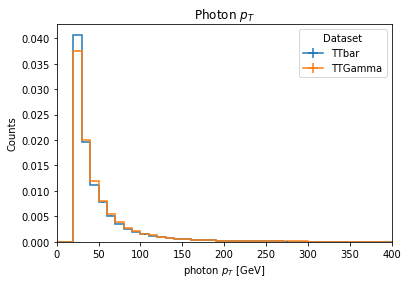

In [8]:
hist.plot1d(outputMC['photon_pt_hist'],overlay='dataset',order=['TTbar','TTGamma'],stack=False,density=True)
plt.title("Photon $p_T$")
plt.show()

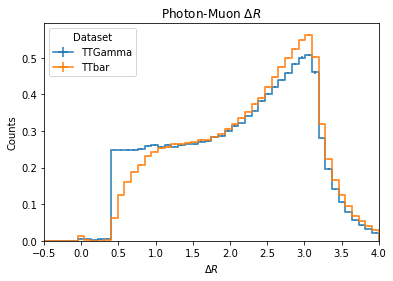

In [9]:
hist.plot1d(outputMC['deltaR_photon_lepton_hist'],overlay='dataset',stack=False,density=True)
plt.title("Photon-Muon $\Delta R$")
plt.show()

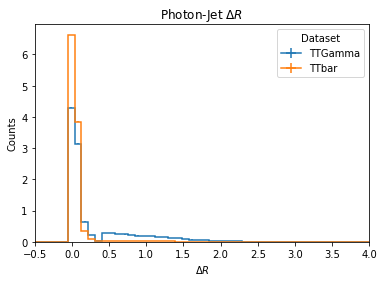

In [10]:
hist.plot1d(outputMC['deltaR_photon_jet_hist'],overlay='dataset',stack=False,density=True)
plt.title("Photon-Jet $\Delta R$")
plt.show()

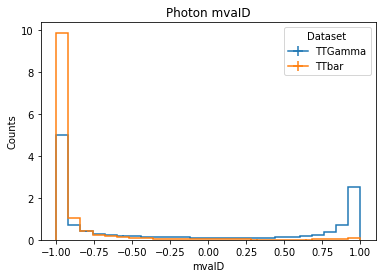

In [11]:
hist.plot1d(outputMC['photon_mvaid_hist'],stack=False,density=True)
plt.xlim(-1.1,1.1)
plt.title("Photon mvaID")
plt.show()

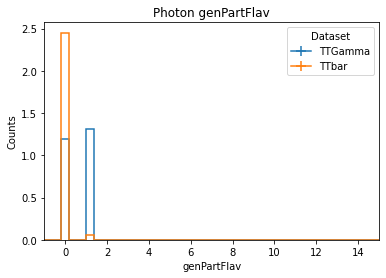

In [12]:
### label ###

hist.plot1d(outputMC['photon_genPartFlav_hist'],overlay='dataset',stack=False,density=True)
plt.title("Photon genPartFlav")
plt.show()

## Preprocessing data for training

In [13]:
print(np.array(outputMC['photon_count'].value))
print(np.array(outputMC['photon_count'].value).shape) # one entry per event, not per photon
print(np.array(outputMC['photon_pt'].value).shape)

[2 1 1 ... 1 2 1]
(1088137,)
(1362199,)


In [14]:
df = pd.DataFrame({
    'photon_pt': np.array(outputMC['photon_pt'].value),
    'photon_eta': np.array(outputMC['photon_eta'].value),
    'photon_phi': np.array(outputMC['photon_phi'].value),
    'photon_hoe': np.array(outputMC['photon_hoe'].value),
    'photon_r9': np.array(outputMC['photon_r9'].value),
    'photon_sieie': np.array(outputMC['photon_sieie'].value),
    'photon_pfRelIso03_all': np.array(outputMC['photon_pfRelIso03_all'].value),
    'photon_pfRelIso03_chg': np.array(outputMC['photon_pfRelIso03_chg'].value),
    #'photon_count': np.array(outputMC['photon_count'].value),
    
    'deltaR_photon_lepton': np.array(outputMC['deltaR_photon_lepton'].value),
    'deltaR_photon_jet': np.array(outputMC['deltaR_photon_jet'].value),
    
    'file': np.array(outputMC['file'].value), # for mvaID comparison, will remove from training set
    
    'photon_genPartFlav': np.array(outputMC['photon_genPartFlav'].value), ## TARGET ##
})
df.describe()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet,file,photon_genPartFlav
count,1.362199e+06,1.362199e+06,1.362199e+06,1.362199e+06,1.362199e+06,1.362199e+06,1.362199e+06,1.362199e+06,1.362199e+06,1.362199e+06,1.362199e+06,1.362199e+06
mean,4.906322e+01,3.509713e-03,1.244407e-02,1.825231e-01,7.260737e-01,1.291206e-02,8.421099e-01,4.979452e-01,2.179716e+00,1.699817e-01,4.793463e-01,2.635562e-01
std,4.210622e+01,7.761611e-01,1.815535e+00,1.619427e-01,2.515710e-01,3.842901e-03,9.496977e-01,6.050608e-01,8.691922e-01,3.538638e-01,4.995734e-01,4.657082e-01
min,2.000001e+01,-1.444092e+00,-3.141602e+00,0.000000e+00,8.843994e-02,1.957417e-04,0.000000e+00,0.000000e+00,6.103516e-05,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.546105e+01,-6.296387e-01,-1.559814e+00,1.556396e-02,5.478516e-01,9.407043e-03,1.769875e-01,6.402592e-02,1.475775e+00,2.141247e-02,0.000000e+00,0.000000e+00
50%,3.477301e+01,8.710861e-03,1.387024e-02,1.738281e-01,7.490234e-01,1.229095e-02,5.840967e-01,3.181359e-01,2.314305e+00,4.039979e-02,0.000000e+00,0.000000e+00
75%,5.539150e+01,6.379395e-01,1.586426e+00,3.095703e-01,9.282227e-01,1.573181e-02,1.181197e+00,7.093032e-01,2.893131e+00,8.766920e-02,1.000000e+00,1.000000e+00
max,1.324450e+03,1.444092e+00,3.141602e+00,3.257812e+00,2.051562e+01,3.082275e-02,3.100977e+01,1.734663e+01,4.904033e+00,3.610590e+00,1.000000e+00,1.300000e+01


In [15]:
df['photon_genPartFlav'].value_counts()

0     1005571
1      356429
13        199
Name: photon_genPartFlav, dtype: int64

In [16]:
### get rid of other labels ###

df = df[(df['photon_genPartFlav'] == 1) | (df['photon_genPartFlav'] == 0)]
df.describe()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet,file,photon_genPartFlav
count,1.362000e+06,1.362000e+06,1.362000e+06,1.362000e+06,1.362000e+06,1.362000e+06,1.362000e+06,1.362000e+06,1.362000e+06,1.362000e+06,1.362000e+06,1.362000e+06
mean,4.906296e+01,3.511176e-03,1.240310e-02,1.825291e-01,7.260627e-01,1.291248e-02,8.421094e-01,4.979436e-01,2.179723e+00,1.699765e-01,4.792790e-01,2.616953e-01
std,4.210624e+01,7.761697e-01,1.815538e+00,1.619436e-01,2.515188e-01,3.842866e-03,9.496319e-01,6.050220e-01,8.691897e-01,3.538570e-01,4.995706e-01,4.395577e-01
min,2.000001e+01,-1.444092e+00,-3.141602e+00,0.000000e+00,8.843994e-02,1.957417e-04,0.000000e+00,0.000000e+00,6.103516e-05,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.546099e+01,-6.296387e-01,-1.559814e+00,1.556396e-02,5.478516e-01,9.407043e-03,1.770346e-01,6.405202e-02,1.475781e+00,2.141150e-02,0.000000e+00,0.000000e+00
50%,3.477291e+01,8.706093e-03,1.383114e-02,1.738281e-01,7.490234e-01,1.229095e-02,5.841249e-01,3.181566e-01,2.314312e+00,4.039771e-02,0.000000e+00,0.000000e+00
75%,5.539017e+01,6.379395e-01,1.586426e+00,3.095703e-01,9.282227e-01,1.573181e-02,1.181210e+00,7.093005e-01,2.893149e+00,8.766152e-02,1.000000e+00,1.000000e+00
max,1.324450e+03,1.444092e+00,3.141602e+00,3.257812e+00,2.051562e+01,3.082275e-02,3.100977e+01,1.734663e+01,4.904033e+00,3.610590e+00,1.000000e+00,1.000000e+00


In [17]:
df['photon_genPartFlav'].value_counts()

0    1005571
1     356429
Name: photon_genPartFlav, dtype: int64

In [18]:
df.head()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet,file,photon_genPartFlav
0,79.276085,-0.075348,-2.450684,0.164062,0.435791,0.014397,0.047569,0.023416,2.238493,0.011533,0.0,0
1,29.967369,-0.605591,-1.234375,0.307617,0.895508,0.018478,2.158426,1.643791,3.142428,0.010509,0.0,0
2,66.590996,1.353516,2.028320,0.145020,0.519531,0.010857,0.257907,0.114259,3.289150,0.023781,0.0,0
3,33.870628,0.123627,0.236298,0.281250,0.405762,0.011902,0.931639,0.849794,2.786459,0.316535,0.0,0
4,22.035528,-0.709961,-2.442871,0.267578,0.511230,0.010422,1.443260,0.963974,1.247723,0.066349,0.0,0


In [19]:
### split into train, val, test datasets ###

In [20]:
X = np.array(df.drop(['photon_genPartFlav'],axis=1))
y = df['photon_genPartFlav']

# shuffle & split into training, validation, testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

print(X_train.shape)
print(y_train.max())
print(y_train.min())

(817200, 11)
1
0


In [21]:
# remove dataset variable from X
file_test = X_test[:,-1]
file_test = file_test.reshape(file_test.shape[0],1)

X_train = X_train[:,:-1]
X_val = X_val[:,:-1]
X_test = X_test[:,:-1]

file_test

array([[0.],
       [0.],
       [1.],
       ...,
       [0.],
       [1.],
       [1.]])

In [22]:
# Scale: mean=0, stdev=1
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)

## Build & train model

In [23]:
model = Sequential()
model.add(Dense(32, input_shape=(X_train.shape[1],), activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1,activation="sigmoid"))

model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                352       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.fit(X_train_scaled, y_train, epochs=5, batch_size=512)

Epoch 1/5
1597/1597 [==============================] - 5s 3ms/step - loss: 0.1585 - accuracy: 0.9408
Epoch 2/5
1597/1597 [==============================] - 4s 3ms/step - loss: 0.1277 - accuracy: 0.9527
Epoch 3/5
1597/1597 [==============================] - 4s 3ms/step - loss: 0.1237 - accuracy: 0.9541
Epoch 4/5
1597/1597 [==============================] - 4s 3ms/step - loss: 0.1213 - accuracy: 0.9549
Epoch 5/5
1597/1597 [==============================] - 5s 3ms/step - loss: 0.1199 - accuracy: 0.9555


In [25]:
loss, accuracy = model.evaluate(X_test_scaled,y_test,verbose=0)
print(f'Test loss: {round(loss,5)}\nTest accuracy: {round(accuracy,5)}')

Test loss: 0.11881
Test accuracy: 0.95515


In [26]:
y_pred = model.predict(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
area_under_curve = auc(fpr, tpr)

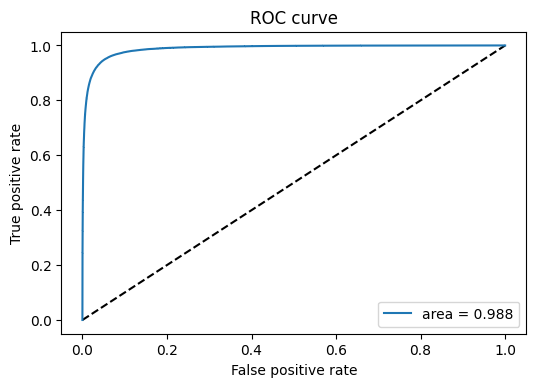

In [27]:
plt.figure(figsize=(6,4),dpi=100)

plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='area = {:.3f}'.format(area_under_curve))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [28]:
predTrue  = y_pred[y_test==True]
predFalse = y_pred[y_test==False]

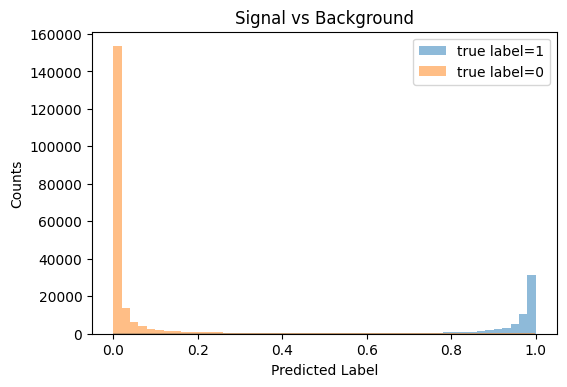

In [40]:
plt.figure(figsize=(6,4),dpi=100)

plt.hist(predTrue,bins=50,alpha=0.5,label='true label=1')
plt.hist(predFalse,bins=50,alpha=0.5,label='true label=0')

plt.xlabel('Predicted Label')
plt.ylabel('Counts')
plt.title("Signal vs Background")
plt.legend(loc='best')
plt.show()

### Evaluate the model on data

In [30]:
df_data = pd.DataFrame({
    'photon_pt': np.array(outputData['photon_pt'].value),
    'photon_eta': np.array(outputData['photon_eta'].value),
    'photon_phi': np.array(outputData['photon_phi'].value),
    'photon_hoe': np.array(outputData['photon_hoe'].value),
    'photon_r9': np.array(outputData['photon_r9'].value),
    'photon_sieie': np.array(outputData['photon_sieie'].value),
    'photon_pfRelIso03_all': np.array(outputData['photon_pfRelIso03_all'].value),
    'photon_pfRelIso03_chg': np.array(outputData['photon_pfRelIso03_chg'].value),
    #'photon_count': np.array(outputData['photon_count'].value),
    
    'deltaR_photon_lepton': np.array(outputData['deltaR_photon_lepton'].value),
    'deltaR_photon_jet': np.array(outputData['deltaR_photon_jet'].value),
})
df_data.describe()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet
count,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000
mean,48.844124,-0.001477,-0.006091,0.223218,0.672649,0.013949,1.040128,0.601470,2.249400,0.068099
std,42.629852,0.792872,1.815690,0.155518,0.259802,0.003653,0.972655,0.627394,0.855156,0.166884
min,20.002771,-1.443604,-3.140625,0.000000,0.125732,0.003870,0.000000,0.000000,0.002021,0.000427
25%,24.961231,-0.661133,-1.582153,0.085693,0.501465,0.010864,0.399883,0.188194,1.587928,0.019248
50%,33.986900,-0.000775,0.015211,0.221680,0.672852,0.013824,0.780743,0.426636,2.383305,0.034804
75%,54.494076,0.650574,1.552979,0.343750,0.834473,0.016541,1.361864,0.818062,2.926016,0.060586
max,599.480103,1.443359,3.140137,1.355469,6.789062,0.026962,13.611495,7.809951,4.723557,2.619408


In [31]:
X_data = np.array(df_data)
X_data

array([[ 7.0026939e+01, -8.2226562e-01,  9.8999023e-01, ...,
         1.7563209e-01,  2.3238621e+00,  3.5363540e-02],
       [ 3.3334576e+01, -1.1088867e+00,  2.0371094e+00, ...,
         1.3235191e+00,  1.2296046e+00,  7.9972357e-02],
       [ 2.0946018e+01, -1.2648926e+00, -1.9724121e+00, ...,
         5.3133935e-01,  2.7846978e+00,  1.0364366e-01],
       ...,
       [ 4.4068752e+01, -1.3638306e-01,  2.9589844e-01, ...,
         6.4953488e-01,  3.4395282e+00,  6.8737358e-02],
       [ 3.3182022e+01, -9.5593262e-01, -2.4882812e+00, ...,
         1.2256178e-01,  1.4296978e+00,  3.0139504e-02],
       [ 2.7741516e+01, -5.0134277e-01,  2.5039062e+00, ...,
         5.2707952e-01,  2.3626704e+00,  3.6614634e-02]], dtype=float32)

In [32]:
scaler = StandardScaler()
X_data_scaled=scaler.fit_transform(X_data)

In [33]:
y_pred_data = model.predict(X_data_scaled)

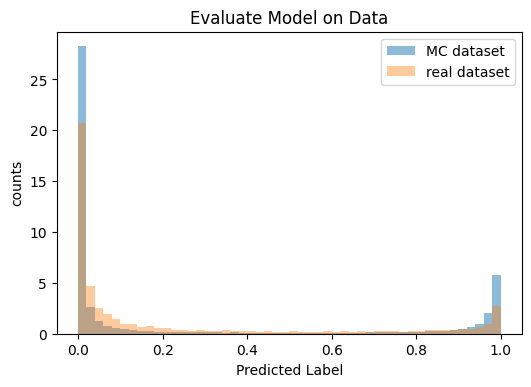

In [34]:
plt.figure(figsize=(6,4),dpi=100)

plt.hist(y_pred,bins=50,alpha=0.5,density=True,label="MC dataset")
plt.hist(y_pred_data,bins=50,alpha=0.4,density=True,label="real dataset")

plt.xlabel("Predicted Label")
plt.ylabel("counts")
plt.title("Evaluate Model on Data")
plt.legend()
plt.show()

### Compare mvaID

In [35]:
# separate y_pred by dataset
y_pred_ttg = y_pred[file_test==1.0]
y_pred_ttb = y_pred[file_test==0.0]

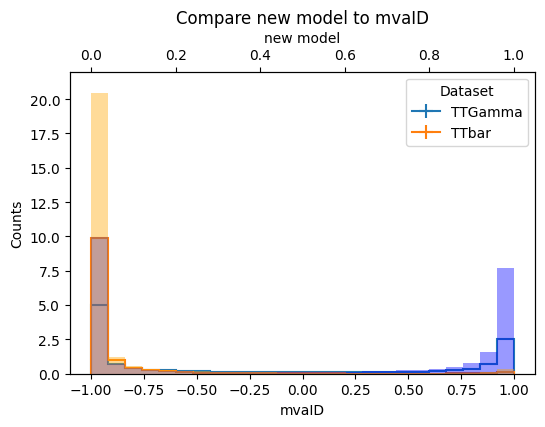

In [36]:
fig, ax1 = plt.subplots(figsize=(6,4),dpi=100)

hist.plot1d(outputMC['photon_mvaid_hist'],stack=False,density=True,ax=ax1)
ax1.set_xlim(-1.1,1.1)

ax2 = ax1.twiny()
ax2.hist(y_pred_ttg,bins=25,density=True,alpha=0.4,color="blue")
ax2.hist(y_pred_ttb,bins=25,density=True,alpha=0.4,color="orange")
ax2.set_xlabel("new model")

plt.ylim(0,22)
plt.title("Compare new model to mvaID")
plt.show()

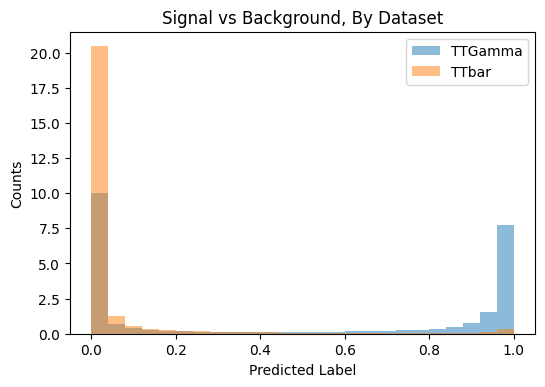

In [37]:
# just new model
plt.figure(figsize=(6,4),dpi=100)

plt.hist(y_pred_ttg,bins=25,density=True,alpha=0.5,label="TTGamma")
plt.hist(y_pred_ttb,bins=25,density=True,alpha=0.5,label="TTbar")

plt.xlabel("Predicted Label")
plt.ylabel("Counts")
plt.title("Signal vs Background, By Dataset")
plt.legend()
plt.show()

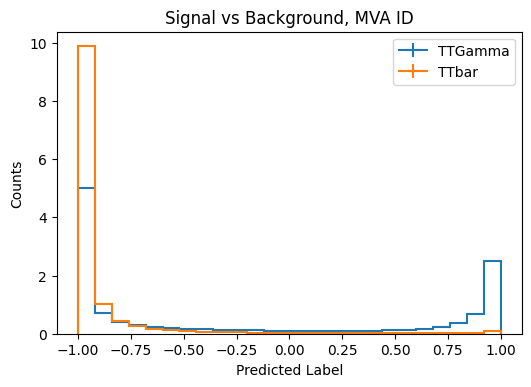

In [38]:
# just MVA ID
plt.figure(figsize=(6,4),dpi=100)

hist.plot1d(outputMC['photon_mvaid_hist'],stack=False,density=True)
plt.xlim(-1.1,1.1)

plt.xlabel("Predicted Label")
plt.ylabel("Counts")
plt.title("Signal vs Background, MVA ID")
plt.legend()
plt.show()